In [ ]:
import networkx as nx
import networkit as nk
from utils import load_graph_v3, anonymize_dataset_to_file
from network_utils import approx_average_shortest_path_length_nk, calculate_avg_clustering_coefficient_nk
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import powerlaw

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Constants
PATH_TO_GRAPH = "spotify_user_network.json"
SEED = 42
CUSTOM_COLOR = "#73D4A2"
sns.set_theme("paper")

In [5]:

G = load_graph_v3(PATH_TO_GRAPH)
anonymized = False
if G.nodes()[0].get("name") is None:
  anonymized = True

selfloops = list(nx.selfloop_edges(G))
print(f"Number of selfloops: {len(selfloops)}")
G.remove_edges_from(selfloops)

G_undirected = G.to_undirected()
G_nk = nk.nxadapter.nx2nk(G_undirected)


Lines read:  60566
Errors found :  0
Number of selfloops: 62


In [6]:
zero_followers = sum(1 for node in G_undirected.nodes() if G_undirected.nodes[node].get('followers_count', 0) == 0)
print(f"Users with zero followers: {zero_followers}")

Users with zero followers: 1312


In [7]:

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
user_indegree_series = pd.Series({n: G_undirected.nodes[n].get("followers_count", G_undirected.degree(n)) for n in G_undirected.nodes})


Nodes: 1077947, Edges: 4730357


In [8]:
#print users with highest indegree
top_users = user_indegree_series.sort_values(ascending=False).head(10)
top_users_out_vs_indegree = {}
for user_id in top_users.index:
    out_degree = G.out_degree(user_id)
    in_degree = G.in_degree(user_id)
    top_users_out_vs_indegree[user_id] = (out_degree, in_degree)
print("Top 10 users by followers count:")
for user_id, followers_count in top_users.items():
    print(f"User ID: {user_id}, Followers Count: {followers_count}")
    print(f"    Out-degree (following): {top_users_out_vs_indegree[user_id][0]}, In-degree (followers): {top_users_out_vs_indegree[user_id][1]}")

Top 10 users by followers count:
User ID: 965847, Followers Count: 736428.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 557968, Followers Count: 712690.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 412688, Followers Count: 504002.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 240256, Followers Count: 246284.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 718443, Followers Count: 211785.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 567148, Followers Count: 202860.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 46, Followers Count: 194234.0
    Out-degree (following): 10082, In-degree (followers): 1000
User ID: 411765, Followers Count: 107705.0
    Out-degree (following): 3, In-degree (followers): 0
User ID: 508345, Followers Count: 96841.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 308, Followers Count: 80756.0
    Out-degree (following): 5333, I

# Small World

In [9]:
AMOUNT_OF_RUNS = 100
SAMPLE_SIZE = 50

In [10]:
#print number of nodes and edges in the networkkit graph
print(f"Networkit Graph - Nodes: {G_nk.numberOfNodes()}, Edges: {G_nk.numberOfEdges()}")
avg_local_clustering = calculate_avg_clustering_coefficient_nk(G_nk)
print(f"Average Local Clustering Coefficient (Networkit): {avg_local_clustering}")
avg_shortest_path_length_nk = approx_average_shortest_path_length_nk(G_nk, SAMPLE_SIZE)
print(f"Approx. Average Shortest Path Length (Networkit, sampled from {SAMPLE_SIZE} nodes): {avg_shortest_path_length_nk["mean"]}") 

Networkit Graph - Nodes: 1077947, Edges: 4580255
Average Local Clustering Coefficient (Networkit): 0.05498852100052146
Approx. Average Shortest Path Length (Networkit, sampled from 50 nodes): 4.803705395534289


In [11]:
num_nodes = G_nk.numberOfNodes()
avg_degree = (2 * G_nk.numberOfEdges()) / G_nk.numberOfNodes()
print(avg_degree)
k = int(avg_degree)
if k % 2 != 0:
    k += 1 
print(f"Creating regular lattice with {num_nodes} nodes and  {k} neighbors per side")

regular_lattice_generator = nk.generators.RegularRingLatticeGenerator(num_nodes, k)
G_regular_lattice = regular_lattice_generator.generate()
lattice_avg_local_clustering = calculate_avg_clustering_coefficient_nk(G_regular_lattice)
print(f"Average Local Clustering Coefficient (Regular Lattice): {lattice_avg_local_clustering}")
lattice_avg_shortest_path_len = approx_average_shortest_path_length_nk(G_regular_lattice, SAMPLE_SIZE)
print(f"Average shortest path Len (Regular Lattice): {lattice_avg_shortest_path_len}")


8.498107977479412
Creating regular lattice with 1077947 nodes and  8 neighbors per side
Average Local Clustering Coefficient (Regular Lattice): 0.7000000000000002
Average shortest path Len (Regular Lattice): {'mean': np.float64(33686.281251304565), 'std_dev': np.float64(19448.530958565712), 'count': 53897350}


In [12]:
avg_shortest_path_lengths = []
largest_component_sizes = []
avg_local_clusterings = []
for _ in range(10):
    G_rand_curveball = nk.randomization.GlobalCurveball(G_nk, number_of_global_rounds=SAMPLE_SIZE)
    G_rand_curveball.run()
    G_randomized = G_rand_curveball.getGraph()
    G_largest_cc = nk.components.ConnectedComponents(G_randomized).extractLargestConnectedComponent(G_randomized, compactGraph=True)
    largest_component_sizes.append(G_largest_cc.numberOfNodes())
    avg_shortest_path_length_local = approx_average_shortest_path_length_nk(G_largest_cc, SAMPLE_SIZE)
    avg_shortest_path_lengths.append(avg_shortest_path_length_local["mean"])
    avg_local_clustering_coeff = calculate_avg_clustering_coefficient_nk(G_largest_cc)
    avg_local_clusterings.append(avg_local_clustering_coeff)
avg_random_shortest_path_length = np.mean(avg_shortest_path_lengths)
avg_graph_size = np.mean(largest_component_sizes)
avg_random_local_clustering = np.mean(avg_local_clusterings)
print(f"Approx. Average Shortest Path Length (Randomized Graphs, generated from graphs with average size of {avg_graph_size}: {avg_random_shortest_path_length}")
print(f"Average Local Clustering Coeffs: {avg_random_local_clustering}")

Approx. Average Shortest Path Length (Randomized Graphs, generated from graphs with average size of 932794.2: 3.975399910817939
Average Local Clustering Coeffs: 0.012346609804962612


## Sigma

In [13]:

nominator = avg_local_clustering/avg_random_local_clustering
denominator = avg_shortest_path_length_nk["mean"]/avg_random_shortest_path_length
print(f"Nominator: {nominator}")
print(f"Denominator: {denominator}")

sigma = nominator/denominator
print(f"Sigma: {sigma}")

Nominator: 4.453734415290205
Denominator: 1.2083577761478406
Sigma: 3.6857746134496656


## Omega

In [14]:
print(f"{avg_random_shortest_path_length} / {avg_shortest_path_length_nk['mean']} - {avg_local_clustering} / {lattice_avg_local_clustering} ") 
omega = (avg_random_shortest_path_length / avg_shortest_path_length_nk["mean"]) - (avg_local_clustering / lattice_avg_local_clustering)
print(f"Omega: {omega}")

3.975399910817939 / 4.803705395534289 - 0.05498852100052146 / 0.7000000000000002 
Omega: 0.7490144363769445


## Power Law Test

In [15]:
followers_data = user_indegree_series[(user_indegree_series > 0)].values

fit = powerlaw.Fit(followers_data, discrete=True)

print("Power Law Analysis Results:")
print(f"Alpha (power law exponent): {fit.power_law.alpha:.3f}")
print(f"xmin: {fit.power_law.xmin:.2f}")
print(f"Data points used: {len(followers_data[followers_data >= fit.power_law.xmin])}/{len(followers_data)}")

Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 4913/4913 [00:39<00:00, 123.89it/s]

Power Law Analysis Results:
Alpha (power law exponent): 1.859
xmin: 30.00
Data points used: 440913/1040216


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


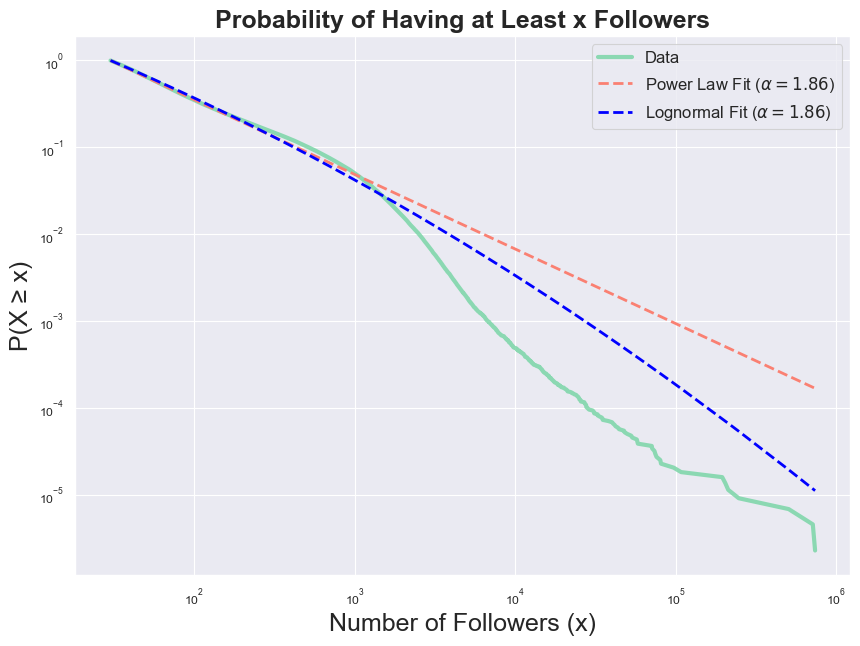

In [16]:
plt.figure(figsize=(10, 7))
fit.plot_ccdf(original_data=False,
              color=CUSTOM_COLOR, 
              linewidth=3, 
              alpha=0.8, 
              label="Data")

fit.power_law.plot_ccdf(color='salmon', linestyle='--', linewidth=2, label=f'Power Law Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.lognormal.plot_ccdf(color='blue', linestyle='--', linewidth=2, label=f'Lognormal Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
plt.title("Probability of Having at Least x Followers", fontsize=18, fontweight='bold')
plt.xlabel("Number of Followers (x)", fontsize=18)
plt.ylabel("P(X ≥ x)", fontsize=18)
plt.legend(frameon=True, fontsize=12)

plt.savefig("followers_ccdf_powerlaw.eps", format="eps", transparent=False, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


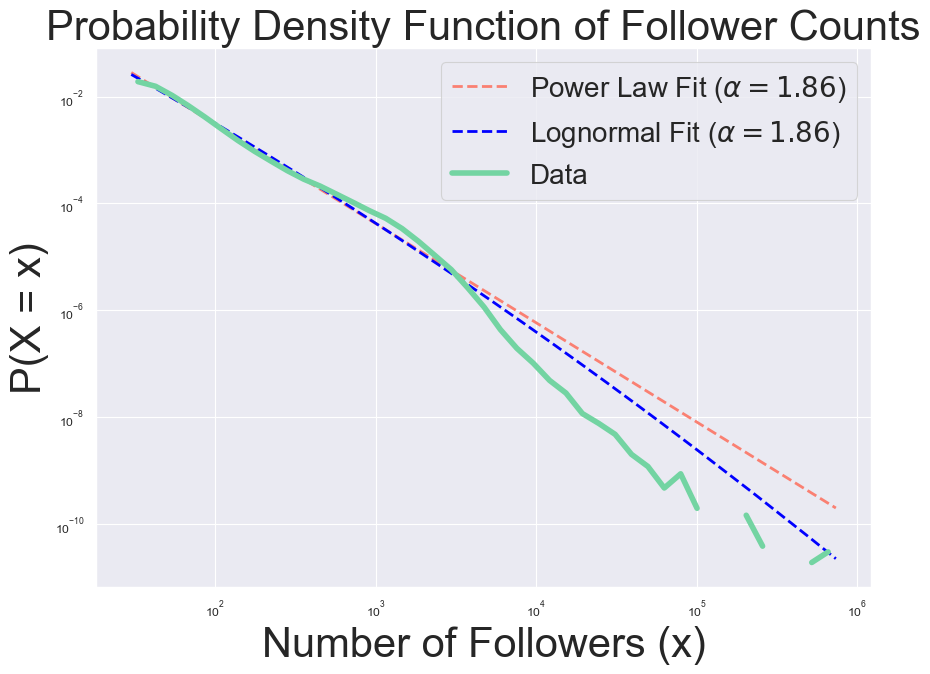

In [17]:
plt.figure(figsize=(10, 7))
fit.power_law.plot_pdf(color='salmon', linestyle='--', linewidth=2, label=f'Power Law Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.lognormal.plot_pdf(color='blue', linestyle='--', linewidth=2, label=f'Lognormal Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.plot_pdf(original_data=False,
              color=CUSTOM_COLOR, 
              linewidth=4, 
              label="Data")

plt.title("Probability Density Function of Follower Counts", fontsize=30)
plt.xlabel("Number of Followers (x)", fontsize=30)
plt.ylabel("P(X = x)", fontsize=30)
plt.legend(frameon=True, fontsize=20)

plt.savefig("followers_pdf_powerlaw.eps", format="eps", transparent=False, bbox_inches='tight')
plt.show()

In [18]:
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"R = {R:.3f}, p = {p:.4f}")

R = -35.463, p = 0.0000
